In [1]:
import numpy as np
import random
import scipy.io
import scipy.ndimage
import os
import gc
from PIL import Image
import cv2
import h5py

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = '/ucf_cc_50/'
images = [data+i for i in os.listdir(data) if 'mat' not in i]
images.sort()
print images

['/ucf_cc_50/1.jpg', '/ucf_cc_50/10.jpg', '/ucf_cc_50/11.jpg', '/ucf_cc_50/12.jpg', '/ucf_cc_50/13.jpg', '/ucf_cc_50/14.jpg', '/ucf_cc_50/15.jpg', '/ucf_cc_50/16.jpg', '/ucf_cc_50/17.jpg', '/ucf_cc_50/18.jpg', '/ucf_cc_50/19.jpg', '/ucf_cc_50/2.jpg', '/ucf_cc_50/20.jpg', '/ucf_cc_50/21.jpg', '/ucf_cc_50/22.jpg', '/ucf_cc_50/23.jpg', '/ucf_cc_50/24.jpg', '/ucf_cc_50/25.jpg', '/ucf_cc_50/26.jpg', '/ucf_cc_50/27.jpg', '/ucf_cc_50/28.jpg', '/ucf_cc_50/29.jpg', '/ucf_cc_50/3.jpg', '/ucf_cc_50/30.jpg', '/ucf_cc_50/31.jpg', '/ucf_cc_50/32.jpg', '/ucf_cc_50/33.jpg', '/ucf_cc_50/34.jpg', '/ucf_cc_50/35.jpg', '/ucf_cc_50/36.jpg', '/ucf_cc_50/37.jpg', '/ucf_cc_50/38.jpg', '/ucf_cc_50/39.jpg', '/ucf_cc_50/4.jpg', '/ucf_cc_50/40.jpg', '/ucf_cc_50/41.jpg', '/ucf_cc_50/42.jpg', '/ucf_cc_50/43.jpg', '/ucf_cc_50/44.jpg', '/ucf_cc_50/45.jpg', '/ucf_cc_50/46.jpg', '/ucf_cc_50/47.jpg', '/ucf_cc_50/48.jpg', '/ucf_cc_50/49.jpg', '/ucf_cc_50/5.jpg', '/ucf_cc_50/50.jpg', '/ucf_cc_50/6.jpg', '/ucf_cc_50/7.jpg'

In [ ]:
images_ann = []

for image_name in images:
    images_ann.append(scipy.io.loadmat(image_name.split('.')[0] + '_ann.mat')['annPoints'])

In [ ]:
images_ann_array = []

for k in xrange(len(images_ann)):
    img = cv2.imread(images[k])
    ann_array = np.zeros((img.shape[0], img.shape[1]))
    for i in xrange(len(images_ann[k])):
        yl = np.floor(images_ann[k][i][0]).astype(int)
        xl = np.floor(images_ann[k][i][1]).astype(int)
        
        yl = np.minimum(yl, img.shape[1] - 1)
        xl = np.minimum(xl, img.shape[0] - 1)
        
        ann_array[xl, yl] = 1
        
    images_ann_array.append(ann_array)

In [ ]:
def get_density(images_ann_array, n):
    
    pts = np.array((zip(np.nonzero(images_ann_array[n])[1], np.nonzero(images_ann_array[n])[0]))) #pts contains (x, y) of all annotated points
    
    leafsize = 2048

    tree = scipy.spatial.KDTree(pts.copy(), leafsize = leafsize)
    distances, locations = tree.query(pts, k = 2, eps = 10.)
    
    gt = images_ann_array[n]
    gt_count = np.count_nonzero(gt)

    density = np.zeros(gt.shape, dtype = np.float32)

    for i, pt in enumerate(pts):
            pt2d = np.zeros(gt.shape, dtype = np.float32)
            pt2d[pt[1], pt[0]] = 1
            if gt_count >1:
                sigma = distances[i][1]
            else:
                sigma = np.average(np.array(gt.shape))/2./2.
            density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode = 'constant')
    
    return density

In [ ]:
densities = []   #to store the density arrays of all GT images

for k in xrange(len(images_ann_array)):
    density = get_density(images_ann_array, k)
    densities.append(density)                                             #target images array
    print '{} images processed'.format(k+1)

In [3]:
def rgb2gray(rgb):                                                      #convert RGB images to grayscale
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [4]:
def generate_train_data():                                                 #generate training
    
    X = []                                                                 #this will contain the training images
    
    for image in images:
        img = cv2.imread(image)
        X.append(img)
    
    X_trainer, X_test, Y_trainer, Y_test = train_test_split(X, densities, test_size = 0.2)
    
    return X_trainer, Y_trainer, X_test, Y_test

In [ ]:
densities = np.array(densities) 

def save_densities():                                                     #save the densities
    np.save('densities', densities)                                       
    
save_densities()

In [5]:
def load_densities():
    densities = np.load('/densities/densities.npy')                                     #Load the saved densities
    return densities

densities = load_densities()

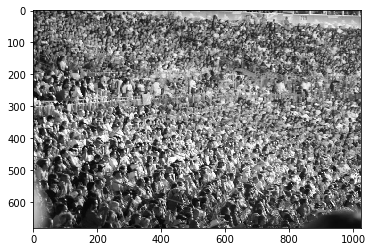

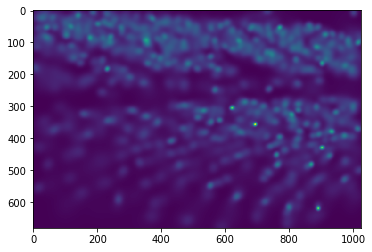

In [6]:
img = cv2.imread(images[21])
plt.imshow(np.asarray(img))
plt.figure()
plt.imshow(densities[21])                                              #Show loaded densities

In [7]:
# data augmentation functions

def multiscale_pyramidal(images, gts, start=0.5, end=1.3, step=0.1):
    frange = np.arange(start, end, step)
    out_images = []
    out_gts = []
    
    for i, img in enumerate(images):
        for f in frange:
            img = np.asarray(img)
            out_images.append(cv2.resize(img, None, fx=f, fy=f, interpolation=cv2.INTER_CUBIC)[..., np.newaxis])
            out_gts.append(cv2.resize(gts[i], None, fx=f, fy=f, interpolation=cv2.INTER_CUBIC)/ (f * f) [..., np.newaxis]) #try using PIL resize in some way
            
    return out_images, out_gts

def generate_slices(X_train, Y_train, slice_w=256, slice_h=256, offset=None):
    
    if offset == None:
        offset = (slice_h + slice_w) // 2
    
    out_images = []
    out_gts = []
    
    for i, img in enumerate(X_train):
        img_h, img_w, _ = img.shape
        
        p_y_y1 = 0
        p_y_y2 = p_y_y1 + slice_h
        
        while p_y_y2 < img_h:
            p_x_x1 = 0
            p_x_x2 = p_x_x1 + slice_w
            
            while p_x_x2 < img_w:
                out_images.append(img[p_y_y1:p_y_y2, p_x_x1:p_x_x2, :])
                out_gts.append(Y_train[i][p_y_y1:p_y_y2, p_x_x1:p_x_x2][..., np.newaxis])
                
                p_x_x1 += offset
                p_x_x2 += offset 
                
            p_y_y1 += offset
            p_y_y2 += offset
            
    return out_images, out_gts

def flip_slices(X_train, Y_train):
    out_images, out_gts = [], []
    for i, img in enumerate(X_train):
        gt = Y_train[i]
        
        out_images.append(img)
        out_gts.append(gt)
        out_images.append(np.fliplr(img))
        out_gts.append(np.fliplr(gt))
    return out_images, out_gts

def samples_distribution(X_train, Y_train):   
    out_images, out_gts = [], []
    gts_count = map(np.sum, Y_train)
    max_count = max(gts_count)
    
    for i, img in enumerate(X_train):
        if gts_count >= 1. and random.random() <  gts_count[i]**2 / max_count**2:
            out_images.append(img)
            out_gts.append(Y_train[i])
    
    neg_count = sum(gt_count < 1 for gt_count in gts_count)
    obj_neg_count = len(out_gts) / 6
    neg_keep_prob = min(1., float(obj_neg_count) / float(neg_count))
    
    for i, img in enumerate(X_train):
        if gts_count[i] < 1. and random.random() < neg_keep_prob:
            out_images.append(img)
            out_gts.append(Y_train[i])
            
    return out_images, out_gts

def shuffle_slices(X_train, Y_train):
    out_images, out_gts = [], []
    indexes = range(len(X_train))
    random.shuffle(indexes)
    
    for i in indexes:
        out_images.append(X_train[i])
        out_gts.append(Y_train[i])
    
    return out_images, out_gts

def convert_data_to_gray(X_train, Y_train):       #convert color images of 225, 225, 3 to gray of size: 225, 225, 1
    out_images, out_gts = [], []

    n = len(X_train)
    
    for i in xrange(n):
        im = rgb2gray(X_train[i])
        im = im[..., np.newaxis]
        out_images.append(im)
        gt = Y_train[i]
        gt = gt[..., np.newaxis]
        out_gts.append(gt)
        
    return out_images, out_gts

In [8]:
#generate training data
X_trainer, Y_trainer, X_test, Y_test = generate_train_data()                             #basic data without augmentation
print 'Training Dataset size'
print len(X_trainer), len(Y_trainer)

X_train, Y_train = convert_data_to_gray(X_trainer, Y_trainer)
X_test, Y_test = convert_data_to_gray(X_test, Y_test)
print 'New shapes of arrays after grayscale conversion'
print X_train[10].shape, Y_train[10].shape, X_test[2].shape, Y_test[2].shape       #converting to gray

X_train, Y_train = multiscale_pyramidal(X_train, Y_train)                           #data augmentation technique 1
print 'Increased size after scaling the images'
print len(X_train), len(Y_train)

X_train, Y_train = generate_slices(X_train, Y_train, slice_w=225, slice_h=225, offset=8) #technique 2
print 'Increased size after generating slices from each image'
print len(X_train), len(Y_train)

X_train, Y_train = flip_slices(X_train, Y_train)                                        #technique 3
print 'After flipping slices'
print len(X_train), len(Y_train) 

X_train, Y_train = samples_distribution(X_train, Y_train)                          #sampling the training set
print 'After sampling distribution'
print len(X_train), len(Y_train)

X_train, Y_train = shuffle_slices(X_train, Y_train)                               #shuffle them images
print 'Just shuffling images now'
print len(X_train), len(Y_train)

Training Dataset size
40 40
New shapes of arrays after grayscale conversion
(680, 1024, 1) (680, 1024, 1) (712, 1024, 1) (712, 1024, 1)
Increased size after scaling the images
320 320
Increased size after generating slices from each image
1148039 1148039
After flipping slices
2296078 2296078
After sampling distribution
32978 32978
Just shuffling images now
32978 32978


In [9]:
X_train = np.asarray(X_train)
X_train = X_train.transpose(0, 3, 1, 2)

In [ ]:
#Saving the array as separate files (optional)
X_train_1, X_train_2, X_train_3, X_train_4, X_train_5, X_train_6, X_train_7, X_train_8, X_train_9, X_train_10 = np.array_split(X_train, 10)

np.save('X_train_1', X_train_1)
np.save('X_train_2', X_train_2)
np.save('X_train_3', X_train_3)
np.save('X_train_4', X_train_4)
np.save('X_train_5', X_train_5)
np.save('X_train_6', X_train_6)
np.save('X_train_7', X_train_7)
np.save('X_train_8', X_train_8)
np.save('X_train_9', X_train_9)
np.save('X_train_10', X_train_10)

In [10]:
#Same as above for Y_train
Y_train = np.asarray(Y_train)
Y_train = Y_train.transpose(0, 3, 1, 2)

In [ ]:
Y_train_1, Y_train_2, Y_train_3, Y_train_4, Y_train_5, Y_train_6, Y_train_7, Y_train_8, Y_train_9, Y_train_10 = np.array_split(Y_train, 10)

np.save('Y_train_1', Y_train_1)
np.save('Y_train_2', Y_train_2)
np.save('Y_train_3', Y_train_3)
np.save('Y_train_4', Y_train_4)
np.save('Y_train_5', Y_train_5)
np.save('Y_train_6', Y_train_6)
np.save('Y_train_7', Y_train_7)
np.save('Y_train_8', Y_train_8)
np.save('Y_train_9', Y_train_9)
np.save('Y_train_10', Y_train_10)

In [11]:
#HIGH LEVEL FEATURE NET
class high_level_feature_net(nn.Module):
    def __init__(self):
        super(high_level_feature_net, self).__init__()
        
        self.features = nn.Sequential(
                                nn.Conv2d(1, 64, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=1),
                                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(512, 512, kernel_size=3, padding=1))
        
    def forward(self, input):
        return self.features(input)

In [12]:
#LOW LEVEL FEATURE NET
class low_level_feature_net(nn.Module):
    def __init__(self):
        super(low_level_feature_net, self).__init__()
        
        self.features = nn.Sequential(
                                      nn.Conv2d(1, 24, kernel_size=5, padding=3),
                                      nn.ReLU(),
                                      nn.AvgPool2d(kernel_size=5, stride=2),
                                      nn.Conv2d(24, 24, kernel_size=5, padding=3),
                                      nn.ReLU(),
                                      nn.AvgPool2d(kernel_size=5, stride=2),
                                      nn.Conv2d(24, 24, kernel_size=5, padding=3),
                                      nn.ReLU(),
                                      nn.AvgPool2d(kernel_size=5, stride=2)
                                )
        
    def forward(self, input):
        return self.features(input)

In [13]:
#PREDICT NET
class predict_net(nn.Module):
    def __init__(self):
        super(predict_net, self).__init__()
        self.conv = nn.Conv2d(536, 1, kernel_size=1, padding=1)
        self.low_level_feature_net = low_level_feature_net().type(dtype)
        self.high_level_feature_net = high_level_feature_net().type(dtype)
        self.upsample = nn.UpsamplingBilinear2d(size=(225, 225))
        
    def forward(self, input):
        low_level_feature = self.low_level_feature_net(input)
        high_level_feature = self.high_level_feature_net(input)
        
        concat_feature = torch.cat([low_level_feature, high_level_feature], 1)
        heat_map = self.conv(concat_feature)
        heat_map = self.upsample(heat_map)
        return heat_map

(1, 225, 225) (1, 225, 225)
Length of X_train: 32978


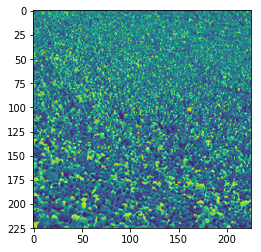

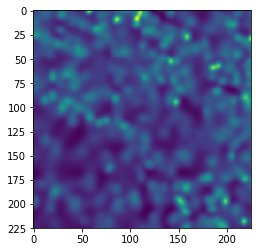

In [14]:
print X_train[1000].shape, Y_train[1000].shape
print 'Length of X_train: {}'.format(len(X_train))
plt.imshow(X_train[2000].squeeze(), cmap='gray')
plt.figure()
plt.imshow(Y_train[2000].squeeze(), cmap='gray')

In [15]:
X_train_tensor = torch.from_numpy(X_train)
Y_train_tensor = torch.from_numpy(Y_train)

In [16]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data = DataLoader(train_dataset, batch_size=16)

In [17]:
# models, loss functions, and optimizers.

dtype = torch.FloatTensor

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

model = predict_net().type(dtype)
loss_fn = nn.MSELoss().type(dtype)

optimizer = optim.Adam(model.parameters())

In [ ]:
epochs = 1

for epoch in xrange(epochs):
    running_loss = 0
    model.train()
    for k, (X, Y) in enumerate(train_data):
        X = Variable(X).type(dtype)
        Y = Variable(Y).type(dtype)

        gen_heatmap = model(X)
        optimizer.zero_grad()
        
        loss = loss_fn(gen_heatmap, Y)
        running_loss += loss.data[0]
        
        if k % 20 == 0:
            if k!=0:
                print 'Mean loss so far, after {} batches, is: {}'.format(k + 1, float(running_loss) / (k + 1))
        
        loss.backward()

        optimizer.step()
    print 'Loss for epoch {} is: {}'.format(epoch, float(running_loss) / k)

Mean loss so far, after 21 batches, is: 0.00019798695714
Mean loss so far, after 41 batches, is: 0.000205590531639
Mean loss so far, after 61 batches, is: 0.000205342819605
Mean loss so far, after 81 batches, is: 0.000201025122042
Mean loss so far, after 101 batches, is: 0.000198919044682
Mean loss so far, after 121 batches, is: 0.000199668782654
Mean loss so far, after 1081 batches, is: 0.000198111063803
Mean loss so far, after 1101 batches, is: 0.000198157969135
Mean loss so far, after 1121 batches, is: 0.000198207373173
Mean loss so far, after 1141 batches, is: 0.000198071831528
Mean loss so far, after 1161 batches, is: 0.00019813330968
Mean loss so far, after 1181 batches, is: 0.000198289605243
Mean loss so far, after 1201 batches, is: 0.000198301731116
Mean loss so far, after 1221 batches, is: 0.000198256669294
Mean loss so far, after 1241 batches, is: 0.000198179148797
Mean loss so far, after 1261 batches, is: 0.000197956228156
Mean loss so far, after 1281 batches, is: 0.00019781

In [26]:
def test_on_image(img):
    im = np.asarray(img)[..., np.newaxis]
    im = im.transpose(2, 0, 1)
    im = im[np.newaxis, ...]
    
    img_tensor = torch.from_numpy(im)
    img_var = Variable(img_tensor).type(dtype)
    gen_heatmap = model(img_var).data.cpu().numpy()
    return gen_heatmap, np.sum(gen_heatmap)

In [27]:
def test_on_full_image(img_address):
    
    img = Image.open(img_address)
    img = img.resize((675, 675), Image.NEAREST)
    img = np.array(img)
    h, w = img.shape

    xp, yp = 0, 0
    x, y = 225, 225
    total = 0
    
    while x <= w:
        yp = 0
        y = 225
        while y <= h:
            hmap, count = test_on_image(img[xp:x, yp:y])
            total += count
            yp +=225
            y +=225
        xp += 225
        x +=225
    print 'Predicted number of people: {}'.format(total)

In [28]:
def test_on_numpy_image(img, gt):
    
    fin_img = np.zeros((675, 675))
    img = np.squeeze(img)
    img = cv2.resize(img, (675, 675), interpolation=cv2.INTER_CUBIC)
    gt = np.squeeze(gt)
    gt = cv2.resize(gt, (675, 675), interpolation=cv2.INTER_CUBIC)
    h, w = img.shape

    xp, yp = 0, 0
    x, y = 225, 225
    total = 0
    
    while x <= w:
        yp = 0
        y = 225
        while y <= h:
            hmap, count = test_on_image(img[xp:x, yp:y])
            fin_img[xp:x, yp:y] = np.squeeze(hmap)
            total += count
            yp +=225
            y +=225
        xp += 225
        x +=225
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.figure()
    plt.imshow(gt, cmap='gray')
    plt.title('Ground Truth')
    plt.figure()
    plt.imshow(fin_img, cmap='gray')
    plt.title('Generated Heatmap')
    return total, np.sum(gt)

In [ ]:
def findMAE(model, X_train, Y_train, X_test, Y_test):
    
    MAE = 0
    
    for i in xrange(10):
        predicted, real, _ = test_on_numpy_image(X_test[i], Y_test[i])
        MAE += np.abs(predicted - real)
        
    for i in xrange(40):
        predicted, real, _ = test_on_numpy_image(X_train[i], Y_train[i])
        MAE += np.abs(predicted-real)
        
    MAE /= 50
    print 'Mean absolute error: {}'.format(MAE)

print len(X_trainer), len(Y_trainer), len(X_test), len(Y_test)
findMAE(model, X_trainer, Y_trainer, X_test, Y_test)

Predicted number of people: 1616.20117188
Actual number of people: 620.158874512


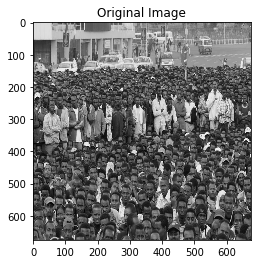

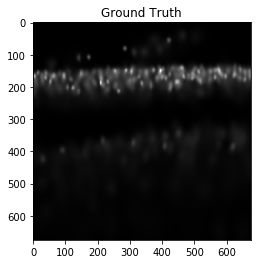

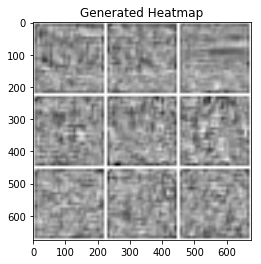

In [29]:
predicted, real, img, gt, fin_img = test_on_numpy_image(X_test[0], Y_test[0])

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.figure()
plt.imshow(gt, cmap='gray')
plt.title('Ground Truth')
plt.figure()
plt.imshow(fin_img, cmap='gray')
plt.title('Generated Heatmap')

In [ ]:
#Saving the model parameters
torch.save(model.state_dict(), 'SimpleE2.pt')

In [23]:
#Loading a pre-trained model
model = predict_net().type(dtype)
model.load_state_dict(torch.load('/model/SimpleE2.pt'))